In [1]:
import pandas as pd
import numpy as np
import numpy as np
import datetime as dt
from collections import defaultdict


def apk(actual, predicted, k=12):
    if len(predicted) > k:
        predicted = predicted[:k]
    score, nhits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            nhits += 1.0
            score += nhits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=12, return_apks=False):
    assert len(actual) == len(predicted)
    apks = [apk(ac, pr, k) for ac, pr in zip(actual, predicted) if 0 < len(ac)]
    if return_apks:
        return apks
    return np.mean(apks)

def iter_to_str(iterable):
    return " ".join(map(lambda x: str(0) + str(x), iterable))


def blend(dt, w=[], k=12):
    if len(w) == 0:
        w = [1] * (len(dt))
    preds = []
    for i in range(len(w)):
        preds.append(dt[i].split())
    res = {}
    for i in range(len(preds)):
        if w[i] < 0:
            continue
        for n, v in enumerate(preds[i]):
            if v in res:
                res[v] += (w[i] / (n + 1))
            else:
                res[v] = (w[i] / (n + 1))    
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    return ' '.join(res[:k])

def prune(pred, ok_set, k=12):
    pred = pred.split()
    post = []
    for item in pred:
        if int(item) in ok_set and not item in post:
            post.append(item)
    return " ".join(post[:k])

In [2]:
df = pd.read_parquet('../data/transactions_train.parquet')
sub = pd.read_csv('../data/sample_submission.csv')
cid = pd.DataFrame(sub.customer_id.apply(lambda s: int(s[-16:], 16)))
customer_id_dict = dict(zip(sub.customer_id.tolist(),[xx[0] for xx in list(cid.values)]))
customer_id_inv_dict = dict(zip([xx[0] for xx in list(cid.values)],sub.customer_id.tolist()))
sub['customer_id'] = cid

In [3]:
customers = pd.read_parquet('../data/customers.parquet')
articles = pd.read_parquet('../data/articles.parquet')

In [4]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,-1,-1,0,0,49,6305
1,11246327431398957306,-1,-1,0,0,25,33726
2,18439897732908966680,-1,-1,0,0,24,3247
3,18352672461570950206,-1,-1,0,0,54,168643
4,18162778555210377306,1,1,0,1,52,168645


In [5]:
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,12855,253,9,0,1010016,0,9,0,...,10,0,0,1,0,16,30,1002,2,8834
1,108775044,108775,12855,253,9,0,1010016,0,10,2,...,10,0,0,1,0,16,30,1002,2,8834
2,108775051,108775,44846,253,9,0,1010017,3,11,11,...,10,0,0,1,0,16,30,1002,2,8834
3,110065001,110065,8159,306,13,4,1010016,0,9,0,...,131,7,7,1,0,61,5,1017,4,8243
4,110065002,110065,8159,306,13,4,1010016,0,10,2,...,131,7,7,1,0,61,5,1017,4,8243


In [6]:
# product_type_name,department_name,graphical_appearance_name,colour_group_name

In [7]:
df.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
25784,2018-09-20,1728846800780188,519773001,0.028458,2,0
25785,2018-09-20,1728846800780188,578472001,0.032525,2,0
5389,2018-09-20,2076973761519164,661795002,0.167797,2,0
5390,2018-09-20,2076973761519164,684080003,0.101678,2,0
47429,2018-09-20,2918879973994241,662980001,0.033881,1,0


In [8]:
df.week.value_counts().head()

39    635891
91    549443
40    518946
62    518403
92    517428
Name: week, dtype: int64

## 召回数据集 

In [9]:
def recall_rules_cmb(val_week,train_type=True):
    actual = df[df.week==val_week].groupby('customer_id')['article_id'].apply(list).reset_index()
    actual['article_id'] = [iter_to_str(xx) for xx in actual['article_id']]
    
    if train_type:
        sub_part = sub[sub.customer_id.isin(actual.customer_id.unique())]
    else:
        sub_part = sub.copy()

        
    ##hot
    sub_actual = pd.merge(sub_part,actual,how='left',on='customer_id')
    sub_actual['prediction'] = iter_to_str(df[df.week.isin([val_week-1])]['article_id'].value_counts().head(24).index.tolist())#24

    ##last buy
    sub_actual_2 = sub_actual.copy()
    del sub_actual_2['prediction']
    last_date = df.loc[df.week < val_week].t_dat.max()

    init_date = last_date - dt.timedelta(days=9999)
    df2 = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()
    df2 = df2.merge(df2.groupby('customer_id').t_dat.max().reset_index().rename(columns={'t_dat':'l_dat'}),
                       on = 'customer_id', how='left')
    df2['d_dat'] = (df2.l_dat - df2.t_dat).dt.days
    df2 = df2.loc[df2.d_dat < 14].sort_values(['t_dat'], ascending=False).drop_duplicates(['customer_id', 'article_id'])
    last_buy = df2.groupby('customer_id')['article_id'].apply(list).reset_index()
    # last_buy = df[df.week.isin([val_week-1,val_week-2,val_week-3])].groupby('customer_id')['article_id'].apply(list).reset_index()
    last_buy['article_id'] = [iter_to_str(xx) for xx in last_buy['article_id']]
    last_buy.columns = ['customer_id','prediction']
    sub_actual_2 = pd.merge(sub_actual_2,last_buy,how='left',on='customer_id')


    ##same color
    init_date = last_date - dt.timedelta(days=6)
    df3 = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
        .groupby(['article_id']).t_dat.count().reset_index()

    adf = pd.read_parquet('../data/articles.parquet')
    adf = adf.merge(df3, on='article_id', how='left').rename(columns={'t_dat':'ct'})\
        .sort_values('ct', ascending=False).query('ct > 0')

    map_to_col = defaultdict(list)
    for aid in adf.article_id.tolist():
        map_to_col[aid] = list(filter(lambda x: x != aid, adf[adf.product_code == aid // 1000].article_id.tolist()))[:1]

    def map_to_variation(s):
        f = lambda item: iter_to_str(map_to_col[int(item)])
        return ' '.join(map(f, s.split()))
    last_buy['other_colors'] = last_buy['prediction'].fillna('').apply(map_to_variation)


    del last_buy['prediction']
    last_buy.columns = ['customer_id','prediction']
    sub_actual_3 = sub_actual.copy()
    del sub_actual_3['prediction']
    sub_actual_3 = pd.merge(sub_actual_3,last_buy,how='left',on='customer_id')
    
    


    
    
    sub_total = pd.merge(sub_actual[['customer_id','article_id','prediction']],\
                         sub_actual_2[['customer_id','prediction']],\
                        how='left',on='customer_id')
    sub_total = pd.merge(sub_total,sub_actual_3[['customer_id','prediction']],\
                        how='left',on='customer_id')

    
    sub_total.columns = ['customer_id','actual','hot','old_buy','other_color']
    sub_total = sub_total.fillna('')

    init_date = last_date - dt.timedelta(days=11)
    sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())
    sub_total['prediction'] = sub_total[['old_buy', 'other_color', 'hot']]\
        .apply(blend, w=[100, 10, 1], axis=1, k=50).apply(prune, ok_set=sold_set, k=48)

    sub_total = sub_total[['customer_id','actual','prediction']]
    sub_total['article_id'] = [[int(xxx) for xxx in xx.split(' ')] if xx!='' else np.nan for xx in sub_total.actual]
    sub_total['pred'] = [[int(xxx) for xxx in xx.split(' ')] if xx!='' else [] for xx in sub_total.prediction]


    return sub_total


In [10]:
#####验证召回的得分
valset_104 = recall_rules_cmb(104)
ap12 = mapk(valset_104.article_id, valset_104.pred, return_apks=True)
map12 = round(np.mean(ap12), 6)
map12 

0.02569

## 排序模型数据集建立

In [11]:
def get_max_dat(feature_week):
    last_date = df.loc[df.week == feature_week].t_dat.max()
    init_date = last_date - dt.timedelta(days=9999)
    print('init_date:',init_date)
    print('last_date:',last_date)

    df2 = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()
    df2 = df2.merge(df2.groupby('customer_id').t_dat.max().reset_index().rename(columns={'t_dat':'l_dat'}),
                       on = 'customer_id', how='left')
    df2['d_dat'] = (df2.l_dat - df2.t_dat).dt.days
    df2 = df2.loc[df2.d_dat < 100000].sort_values(['t_dat'], ascending=False).drop_duplicates(['customer_id', 'article_id'])
    return df2[['customer_id', 'article_id','d_dat']]

In [12]:
def split_row_rank(data, column):
    """拆分成行
    :param data: 原始数据
    :param column: 拆分的列名
    :type data: pandas.core.frame.DataFrame
    :type column: str
    """
    row_len = list(map(len, data[column].values))
    rows = []
    for i in data.columns:
        if i == column:
            row = np.concatenate(data[i].values)
        else:
            row = np.repeat(data[i].values, row_len)
        rows.append(row)
    tmp = pd.DataFrame(np.dstack(tuple(rows))[0], columns=data.columns.tolist())
    tmp = tmp.reset_index()
    tmp['recall_rank'] = tmp.groupby('customer_id')['index'].rank()
    del tmp['index']
    tmp = tmp[['customer_id','pred','recall_rank']]
    tmp.columns = ['customer_id','article_id','recall_rank']
    return tmp

def split_row(data, column):
    """拆分成行
    :param data: 原始数据
    :param column: 拆分的列名
    :type data: pandas.core.frame.DataFrame
    :type column: str
    """
    row_len = list(map(len, data[column].values))
    rows = []
    for i in data.columns:
        if i == column:
            row = np.concatenate(data[i].values)
        else:
            row = np.repeat(data[i].values, row_len)
        rows.append(row)
    return pd.DataFrame(np.dstack(tuple(rows))[0], columns=data.columns)

In [13]:
def gen_train_dataset(valset):
    traindata = valset.copy()
    
    recall_rank_pd = split_row_rank(traindata, 'pred')
    
    traindata['buy_not'] = [list(set(yy)-set(xx)) for (xx,yy) in zip(traindata['article_id'],traindata['pred'])]
    traindata1 = split_row(traindata, 'article_id')
    traindata1['purchased'] = 1
    traindata1 = traindata1[['customer_id','article_id','purchased']]
    traindata0 = split_row(traindata, 'buy_not')
    traindata0['purchased'] = 0
    traindata0 = traindata0[['customer_id','buy_not','purchased']]
    traindata0.columns = ['customer_id','article_id','purchased']
    traindata1.columns = ['customer_id','article_id','purchased']
    traindata01 = pd.concat([traindata0,traindata1]).reset_index(drop=True)
    traindata01 = pd.merge(traindata01,recall_rank_pd,how='left',on=['customer_id','article_id'])
    
    return traindata01

In [14]:
def gen_test_dataset(valset):
    traindata = valset.copy()
    recall_rank_pd = split_row_rank(traindata, 'pred')

    traindata0 = split_row(traindata, 'pred')
    traindata0['purchased'] = 0
    traindata0 = traindata0[['customer_id','pred','purchased']]
    traindata0.columns = ['customer_id','article_id','purchased']
    traindata0 = pd.merge(traindata0,recall_rank_pd,how='left',on=['customer_id','article_id'])

    return traindata0

In [15]:
def gen_feature(traindata01,feature_week):
    
    ## 最近一周购买商品数/type数
    feature_user1 = df[df.week.isin([feature_week])].groupby(['customer_id',])['price'].agg(['count','mean']).reset_index()
    feature_user1.columns = ['customer_id','user_last1_week_buy_number','user_last1_week_buy_price']

    
    ## 最近两周购买商品数
    feature_user2 = df[(df.week<=feature_week)&(df.week>feature_week-3)].groupby(['customer_id',])['price'].agg(['count','mean']).reset_index()
    feature_user2.columns = ['customer_id','user_last2_week_buy_number','user_last2_week_buy_price']

    
    ## 最近三周购买商品数
    feature_user3 = df[(df.week<=feature_week)&(df.week>feature_week-9)].groupby(['customer_id',])['price'].agg(['count','mean']).reset_index()
    feature_user3.columns = ['customer_id','user_last3_week_buy_number','user_last3_week_buy_price'] 

    
    
    ## 最近一周商品数卖出数量
    feature_article1 = df[df.week.isin([feature_week])].groupby(['article_id'])['price'].agg(['count','mean']).reset_index()
    feature_article1.columns = ['article_id','article_last1_week_buy_number','article_last1_week_buy_price']
    ## 最近两周商品数卖出数量
    feature_article2 = df[(df.week<=feature_week)&(df.week>feature_week-3)].groupby(['article_id'])['price'].agg(['count','mean']).reset_index()
    feature_article2.columns = ['article_id','article_last2_week_buy_number','article_last2_week_buy_price']
    ## 最近三周商品数卖出数量
    feature_article3 = df[(df.week<=feature_week)&(df.week>feature_week-9)].groupby(['article_id'])['price'].agg(['count','mean']).reset_index()
    feature_article3.columns = ['article_id','article_last3_week_buy_number','article_last3_week_buy_price']
    
    ###上一周购买次数
    feature1 = df[df.week.isin([feature_week])].groupby(['customer_id','article_id'])['price'].count().reset_index()
    feature1.columns = ['customer_id','article_id','last1_week_buy']
    ###上两周购买次数
    feature2 = df[df.week.isin([feature_week,feature_week-1])].groupby(['customer_id','article_id'])['price'].count().reset_index()
    feature2.columns = ['customer_id','article_id','last2_week_buy']
    ###上三周购买次数
    feature3 = df[df.week.isin([feature_week,feature_week-1,feature_week-2])].groupby(['customer_id','article_id'])['price'].count().reset_index()
    feature3.columns = ['customer_id','article_id','last3_week_buy']
    ##最近一次购买时间
    part = df[(df.week<=feature_week)&(df.week>feature_week-9)]
    last_date_train = part.t_dat.max()
    part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)
    feature4 = part.groupby(['customer_id','article_id'])['day_lag'].min().reset_index()
    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    feature4.columns = ['customer_id','article_id','recent_buy_day_gap']
    feature4['recent_buy_day_gap'] = a / np.sqrt(feature4['recent_buy_day_gap']) +\
                                    b * np.exp(-c*feature4['recent_buy_day_gap']) - d
    feature5 = get_max_dat(feature_week)

    traindataall = pd.merge(traindata01,feature_user1,how='left',on='customer_id')
    traindataall = pd.merge(traindataall,feature_user2,how='left',on='customer_id')
    traindataall = pd.merge(traindataall,feature_article1,how='left',on='article_id')
    traindataall = pd.merge(traindataall,feature_article2,how='left',on='article_id')
    traindataall = pd.merge(traindataall,feature1,how='left',on=['customer_id','article_id'])
    traindataall = pd.merge(traindataall,feature2,how='left',on=['customer_id','article_id'])
    traindataall = pd.merge(traindataall,feature3,how='left',on=['customer_id','article_id'])
    traindataall = pd.merge(traindataall,feature4,how='left',on=['customer_id','article_id'])
    traindataall = pd.merge(traindataall,feature5,how='left',on=['customer_id','article_id'])

    traindataall = pd.merge(traindataall,customers[['customer_id','fashion_news_frequency','age']],
                        how='left',on='customer_id')
    
    traindataall = pd.merge(traindataall,articles[['article_id','product_type_no', 
                                                 'product_group_name', 'graphical_appearance_no',
                                                'colour_group_code',
                                                'perceived_colour_value_id',
                                                'perceived_colour_master_id',
                                                'department_no', 'index_code',
                                                'index_group_no', 'section_no',
                                                'garment_group_no']],
                                                how='left',on='article_id')
    return traindataall



In [16]:

testdata_104 = gen_test_dataset(valset_104)
testdata_104 = gen_feature(testdata_104,104-1)

/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-05-01 00:00:00
last_date: 2020-09-15 00:00:00


In [17]:
traindataall = []
# for ii in range(99,104):  ##260
for ii in range(99,104):
    print('-----')
    valset_103 = recall_rules_cmb(ii)
    ap12 = mapk(valset_103.article_id, valset_103.pred, return_apks=True)
    map12 = round(np.mean(ap12), 6)
    print(ii,map12)
    traindata_103 = gen_train_dataset(valset_103)
    traindata_103 = gen_feature(traindata_103,ii-1)
    traindataall.append(traindata_103)
traindataall = pd.concat(traindataall).reset_index(drop=True)

-----
99 0.021371


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-03-27 00:00:00
last_date: 2020-08-11 00:00:00
-----
100 0.02066


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-04-03 00:00:00
last_date: 2020-08-18 00:00:00
-----
101 0.019448


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-04-10 00:00:00
last_date: 2020-08-25 00:00:00
-----
102 0.022524


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-04-17 00:00:00
last_date: 2020-09-01 00:00:00
-----
103 0.024316


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-04-24 00:00:00
last_date: 2020-09-08 00:00:00


In [18]:
testdata_104.columns 

Index(['customer_id', 'article_id', 'purchased', 'recall_rank',
       'user_last1_week_buy_number', 'user_last1_week_buy_price',
       'user_last2_week_buy_number', 'user_last2_week_buy_price',
       'article_last1_week_buy_number', 'article_last1_week_buy_price',
       'article_last2_week_buy_number', 'article_last2_week_buy_price',
       'last1_week_buy', 'last2_week_buy', 'last3_week_buy',
       'recent_buy_day_gap', 'd_dat', 'fashion_news_frequency', 'age',
       'product_type_no', 'product_group_name', 'graphical_appearance_no',
       'colour_group_code', 'perceived_colour_value_id',
       'perceived_colour_master_id', 'department_no', 'index_code',
       'index_group_no', 'section_no', 'garment_group_no'],
      dtype='object')

In [19]:
testdata_104.groupby('customer_id')['article_id'].count()

customer_id
1402273113592184        24
1827730561464445        36
1951136007097426        24
2639747769247776        34
3177658828628418        24
                        ..
18444954504588539615    32
18445164350380731040    40
18445340048433064259    29
18445641720816255142    31
18446737527580148316    35
Name: article_id, Length: 68984, dtype: int64

In [20]:
features = testdata_104.columns.tolist()[3:]
features

['recall_rank',
 'user_last1_week_buy_number',
 'user_last1_week_buy_price',
 'user_last2_week_buy_number',
 'user_last2_week_buy_price',
 'article_last1_week_buy_number',
 'article_last1_week_buy_price',
 'article_last2_week_buy_number',
 'article_last2_week_buy_price',
 'last1_week_buy',
 'last2_week_buy',
 'last3_week_buy',
 'recent_buy_day_gap',
 'd_dat',
 'fashion_news_frequency',
 'age',
 'product_type_no',
 'product_group_name',
 'graphical_appearance_no',
 'colour_group_code',
 'perceived_colour_value_id',
 'perceived_colour_master_id',
 'department_no',
 'index_code',
 'index_group_no',
 'section_no',
 'garment_group_no']

## 排序模型训练

In [21]:
from lightgbm.sklearn import LGBMRanker
from lightgbm import LGBMClassifier
modellist = []

traindataall.sort_values(by=['customer_id'], inplace=True)
# traindataall = pd.concat([traindata_100,traindata_101,traindata_102,traindata_103])
testdataall = pd.concat([testdata_104])

y = traindataall['purchased']

train_baskets = traindataall.groupby(['customer_id'])['article_id'].count().values


ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    max_depth=7,
    n_estimators=300,
    importance_type='gain',
    verbose=10
)

ranker = ranker.fit(
        traindataall[features],
        y,
        group=train_baskets,
    )

# ranker = LGBMClassifier(random_state=42)
# ranker.fit(traindataall[features],y)
modellist.append(ranker)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.897146
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.287726
[LightGBM] [Debug] init for col-wise cost 0.520258 seconds, init for row-wise cost 2.220293 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.841175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 2676
[LightGBM] [Info] Number of data points in the train set: 12484970, number of used features: 27
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [D

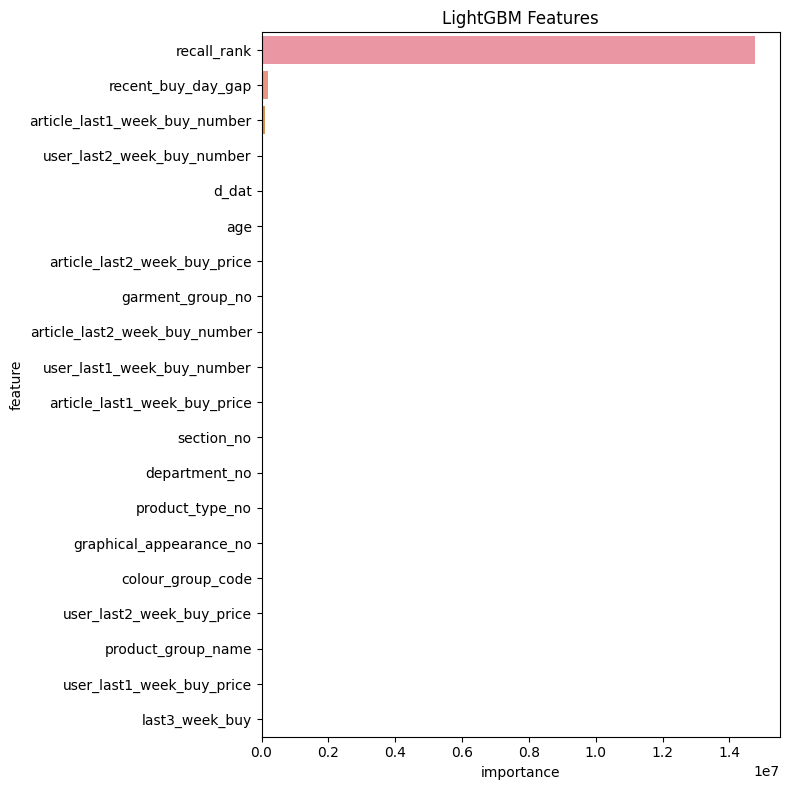

In [22]:
def print_gbm_model_feature_importance(model):
    feature_names = features
    importances = list(model.feature_importances_)
    feature_importances = [(feature,round(importance)) for feature,importance in zip(feature_names,importances)]
    feature_importances = sorted(feature_importances,key=lambda x:x[1],reverse=True)
    return feature_importances
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance_df = []
for model in [ranker]:
    feature_importance_df_ = print_gbm_model_feature_importance(model)
    feature_importance_df_ = pd.DataFrame(feature_importance_df_)
    feature_importance_df_.columns = ["feature", "importance"]
    feature_importance_df.append(feature_importance_df_)
feature_importance_df = pd.concat(feature_importance_df)
feature_importance_df = feature_importance_df.groupby('feature')['importance'].mean().reset_index()

sss = feature_importance_df.sort_values(by="importance", ascending=False).head(20)

plt.figure(figsize=(8,8))
sns.barplot(x="importance", y="feature", 
            data=sss)
plt.title('LightGBM Features')
plt.tight_layout()

In [23]:
pred = 0
for ranker in modellist:
#     tmp = ranker.predict_proba(testdataall[features])[:,1]
    tmp = ranker.predict(testdataall[features])
    pred+=tmp/len(modellist)

In [24]:
testdataall['pred'] = pred

In [25]:
testdataall_pred = testdataall.sort_values(by='pred',ascending=False).reset_index(drop=True)
testdataall_pred = testdataall_pred.groupby('customer_id')['article_id'].apply(list)


In [26]:
testdataall_pred = testdataall_pred.reset_index()
testdataall_pred.columns = ['customer_id','pred_lgb']
testdataall_pred

,customer_id,pred_lgb
0,1402273113592184,"[865799006, 918292001, 448509014, 809238001, 9..."
1,1827730561464445,"[760084003, 894668002, 894668003, 547780001, 8..."
2,1951136007097426,"[865799006, 918292001, 924243001, 918522001, 7..."
3,2639747769247776,"[896161001, 889870001, 865929003, 885951001, 9..."
4,3177658828628418,"[865799006, 918292001, 448509014, 809238001, 9..."
...,...,...
68979,18444954504588539615,"[756318001, 918292001, 807244017, 756318007, 4..."
68980,18445164350380731040,"[610776002, 610776068, 708138026, 918292001, 7..."
68981,18445340048433064259,"[906612002, 906612001, 903141001, 915526002, 9..."
68982,18445641720816255142,"[492892002, 918292001, 751471043, 751471001, 9..."


In [27]:
valset_104_lgb = pd.merge(valset_104,testdataall_pred,how='left',on='customer_id')

In [28]:
valset_104_lgb['pred_lgb'] = [[] if str(xx)=='nan' else xx for xx in valset_104_lgb.pred_lgb]


In [29]:
valset_104_lgb.head(2)

,customer_id,actual,prediction,article_id,pred,pred_lgb
0,8215006181404469139,0624486001,0771602001 0706371005 0771602002 0706371001 09...,[624486001],"[771602001, 706371005, 771602002, 706371001, 9...","[918292001, 751471043, 448509014, 865799006, 7..."
1,8282976502227659861,0827487003,0889036004 0880017001 0621381012 0640021012 09...,[827487003],"[889036004, 880017001, 621381012, 640021012, 9...","[889036004, 621381012, 640021012, 880017001, 6..."


In [30]:
#### 排序后的模型得分
ap12 = mapk(valset_104_lgb.article_id, valset_104_lgb.pred_lgb, return_apks=True)
map12 = round(np.mean(ap12), 6)
map12

0.028006

In [31]:
ap12 = mapk(valset_104_lgb.article_id, valset_104_lgb.pred, return_apks=True)
map12 = round(np.mean(ap12), 6)
map12

0.02569

###排序后验证得分从0.02569提高到了0.0280

## 把验证数据也加进到模型里面重新训练；使用99-104周的数据

In [32]:
traindataall = []
for ii in range(99,105):  
    print('-----')
    valset_103 = recall_rules_cmb(ii)
    ap12 = mapk(valset_103.article_id, valset_103.pred, return_apks=True)
    map12 = round(np.mean(ap12), 6)
    print(ii,map12)
    traindata_103 = gen_train_dataset(valset_103)
    traindata_103 = gen_feature(traindata_103,ii-1)
    traindataall.append(traindata_103)
traindataall = pd.concat(traindataall).reset_index(drop=True)

-----
99 0.021371


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-03-27 00:00:00
last_date: 2020-08-11 00:00:00
-----
100 0.02066


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-04-03 00:00:00
last_date: 2020-08-18 00:00:00
-----
101 0.019448


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-04-10 00:00:00
last_date: 2020-08-25 00:00:00
-----
102 0.022524


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-04-17 00:00:00
last_date: 2020-09-01 00:00:00
-----
103 0.024316


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-04-24 00:00:00
last_date: 2020-09-08 00:00:00
-----
104 0.02569


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-05-01 00:00:00
last_date: 2020-09-15 00:00:00


In [33]:
from lightgbm.sklearn import LGBMRanker
from lightgbm import LGBMClassifier
modellist = []

traindataall.sort_values(by=['customer_id'], inplace=True)

y = traindataall['purchased']

train_baskets = traindataall.groupby(['customer_id'])['article_id'].count().values


ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    max_depth=7,
    n_estimators=300,
    importance_type='gain',
    verbose=10
)

ranker = ranker.fit(
        traindataall[features],
        y,
        group=train_baskets,
    )

modellist.append(ranker)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.897745
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.289374
[LightGBM] [Debug] init for col-wise cost 0.398681 seconds, init for row-wise cost 2.275438 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.689701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 2671
[LightGBM] [Info] Number of data points in the train set: 14765910, number of used features: 27
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [D

In [34]:
del traindataall
import gc
gc.collect()

50

## 生成最终的预测提交文件

In [35]:
def recall_rules(val_week):
    top_sell_person = df[df.week.isin([val_week-1,val_week-2,val_week-3])].groupby('customer_id')['article_id'].apply(lambda x:x.value_counts().index[:12].tolist())
    top_sell_person = top_sell_person.reset_index()
    top_sell_person.columns = ['customer_id','pred']
    valset = df[df.week==val_week].groupby('customer_id')['article_id'].apply(list).reset_index()
    valset = pd.merge(valset,top_sell_person,how='left',on='customer_id')
    top_sell = df[df.week.isin([val_week-1])].article_id.value_counts().index.tolist()[:12]
    valset['pred'] = [top_sell if str(xx)=='nan' else xx for xx in valset.pred]
    valset['pred'] = [xx+top_sell[:(12-len(xx))] if len(xx)<12 else xx for xx in valset.pred]
    return valset



In [36]:
test_week = 105
valset_105 = recall_rules_cmb(test_week,train_type=False)

/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/461067078.py:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  actual = df[df.week==val_week].groupby('customer_id')['article_id'].apply(list).reset_index()


In [37]:
valset_105.head()

,customer_id,actual,prediction,article_id,pred
0,6883939031699146327,,0568601043 0568601006 0924243001 0924243002 09...,NaN,"[568601043, 568601006, 924243001, 924243002, 9..."
1,11246327431398957306,,0826211002 0924243001 0924243002 0918522001 09...,NaN,"[826211002, 924243001, 924243002, 918522001, 9..."
2,18439897732908966680,,0794321007 0794321008 0924243001 0924243002 09...,NaN,"[794321007, 794321008, 924243001, 924243002, 9..."
3,18352672461570950206,,0924243001 0924243002 0918522001 0923758001 08...,NaN,"[924243001, 924243002, 918522001, 923758001, 8..."
4,18162778555210377306,,0791587015 0927530004 0730683050 0896152002 07...,NaN,"[791587015, 927530004, 730683050, 896152002, 7..."


In [38]:
valset_105['customer_id'] = [customer_id_inv_dict[xx] for xx in valset_105['customer_id']]

In [39]:
del valset_105['article_id']

In [40]:
valset_105['customer_id'].nunique()

1371980

In [41]:
testdata_105 = gen_test_dataset(valset_105)


In [42]:
testdata_105.customer_id.nunique()

1371977

In [43]:
testdata_105['customer_id'] = [customer_id_dict[xx] for xx in testdata_105['customer_id']]

In [44]:
testdata_105['article_id'] = testdata_105['article_id'].astype(int)
testdata_105.head()

,customer_id,article_id,purchased,recall_rank
0,6883939031699146327,568601043,0,1.0
1,6883939031699146327,568601006,0,2.0
2,6883939031699146327,924243001,0,3.0
3,6883939031699146327,924243002,0,4.0
4,6883939031699146327,918522001,0,5.0


In [45]:
testdata_105 = gen_feature(testdata_105,105-1)


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2519351787.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  part['day_lag'] = ((last_date_train - part['t_dat']) / np.timedelta64(1, 'D')).astype(int)


init_date: 1993-05-08 00:00:00
last_date: 2020-09-22 00:00:00


In [46]:
from tqdm import tqdm
pred_test = 0
for ranker in modellist:
    tmp2 = []
    for ii in tqdm(range(int(len(testdata_105)/5000000)+1)):
        tmp = ranker.predict(testdata_105[features][ii*5000000:(ii+1)*5000000])
    #     tmp = ranker.predict_proba(testdata_105[features])[:,1]
        tmp2.append(tmp)
    tmp2 = np.concatenate(tmp2)
    pred_test+=tmp2/len(modellist)

100%|██████████| 8/8 [06:00<00:00, 45.11s/it]


In [47]:
testdata_105['article_id'] = testdata_105['article_id'].astype(int)
testdata_105['pred'] = pred_test

In [48]:
testdata_105 = testdata_105.sort_values(by='pred',ascending=False).reset_index(drop=True)
testdata_105 = testdata_105.groupby('customer_id').head(12)
testdata_105 = testdata_105.groupby('customer_id')['article_id'].apply(list)


In [49]:
testdata_105 = testdata_105.reset_index()

In [50]:
testdata_105.head()

,customer_id,article_id
0,4245900472157,"[803757001, 715624001, 715624010, 924243001, 9..."
1,23962613628581,"[732842001, 732842002, 918522001, 924243001, 9..."
2,25398598941468,"[918522001, 924243001, 918292001, 923758001, 9..."
3,28847241659200,"[925246001, 760084003, 924243001, 918522001, 7..."
4,41046458195168,"[924243001, 918522001, 918292001, 866731001, 7..."


In [51]:
testdata_105['customer_id_trans'] = \
        [customer_id_inv_dict[xx] if xx in customer_id_inv_dict else 'nan' for xx in testdata_105['customer_id']]


In [52]:
sub_save = testdata_105[['customer_id_trans','article_id']]
sub_save['article_id'] = [iter_to_str(xx) for xx in sub_save.article_id]
sub_save.columns = ['customer_id','prediction']


/var/folders/0x/h466n4kx6xg0krc0fqzwt2cm0000gn/T/ipykernel_27545/2699840509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_save['article_id'] = [iter_to_str(xx) for xx in sub_save.article_id]


In [53]:
sub_ori = pd.read_csv('../data/sample_submission.csv')

In [54]:
sub_final = pd.merge(sub_ori[['customer_id']],sub_save[['customer_id', 'prediction']],how='left',on='customer_id')

In [55]:
sub_final[['customer_id', 'prediction']].to_csv('submission.csv', index=False)  

In [56]:
sub_final.shape

(1371980, 2)

In [57]:
sub_final

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601006 0568601043 0924243001 0918522001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0673677002 0918522001 0924243001 0923758001 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321008 0924243001 0918522001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0924243002 0918522001 0923758001 0924243001 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587001 0896152002 0791587015 08...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0791587001 0720125007 0720125039 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0624486001 0762846031 0924243001 0918522001 09...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846006 0762846027 0924243001 0884081001 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0918522001 0924243001 0918292001 08...
